In [1]:
import base64
import email
import os
import re
from datetime import datetime

from lxml import etree
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# parse information from email content

# email format up to september 2023
def parse_old_mail(content: str) -> dict | None:
    tree = etree.HTML(content)
    lessons = tree.xpath(
        "//*[contains(text(),'Lessons finished')]/ancestor::tr[1]/following-sibling::tr[1]//b[@class='card-value chameleon-heading']/text()"
    )
    minutes = tree.xpath(
        "//*[contains(text(),'Time learning')]/ancestor::tr[1]/following-sibling::tr[1]//b[@class='stat-value chameleon-heading']/text()"
    )
    if len(lessons) == 1 and len(minutes) == 3:
        return {
            'lessons': int(lessons[0].strip()),
            'minutes': int(minutes[0].strip()) * 60 + int(minutes[1].strip())
        }

# new email format afterwards
def parse_new_mail(content: str) -> dict | None:
    lessons = re.search(r'(\d+)\s*lessons?\s*\</h2', content.strip(), re.IGNORECASE)
    minutes = re.search(r'(\d+)\s*minutes?\s*\</h2', content.strip(), re.IGNORECASE)
    if lessons:
        return {
            'lessons': int(lessons.group(1)),
            'minutes': int(minutes.group(1))
        }        

parsers = [parse_old_mail, parse_new_mail]

In [3]:
# gather data

directory = 'emails'
data = list()

for filename in os.listdir(directory):
    if not filename.endswith('.eml'): 
        continue
    path = os.path.join(directory, filename)
    
    with open(path, 'r') as eml_file:
        msg = email.message_from_file(eml_file)

    if not 'duolingo' in msg['From'].casefold():
        continue

    for part in msg.walk():
        if part.get_content_type() != 'text/html':
            continue
        if part.get('Content-Transfer-Encoding') != 'base64':
            continue
        content = base64.b64decode(part.get_payload()).decode()

        try:
            result = next((result for parser in parsers if (result := parser(content))))
        except StopIteration:
            continue
        result['date'] = datetime.strptime(msg['date'], '%a, %d %b %Y %H:%M:%S +0000')
        data.append(result)
        break

df = pd.DataFrame(data).set_index('date').sort_index()
df['minutes/lesson'] = df['minutes'] / df['lessons']

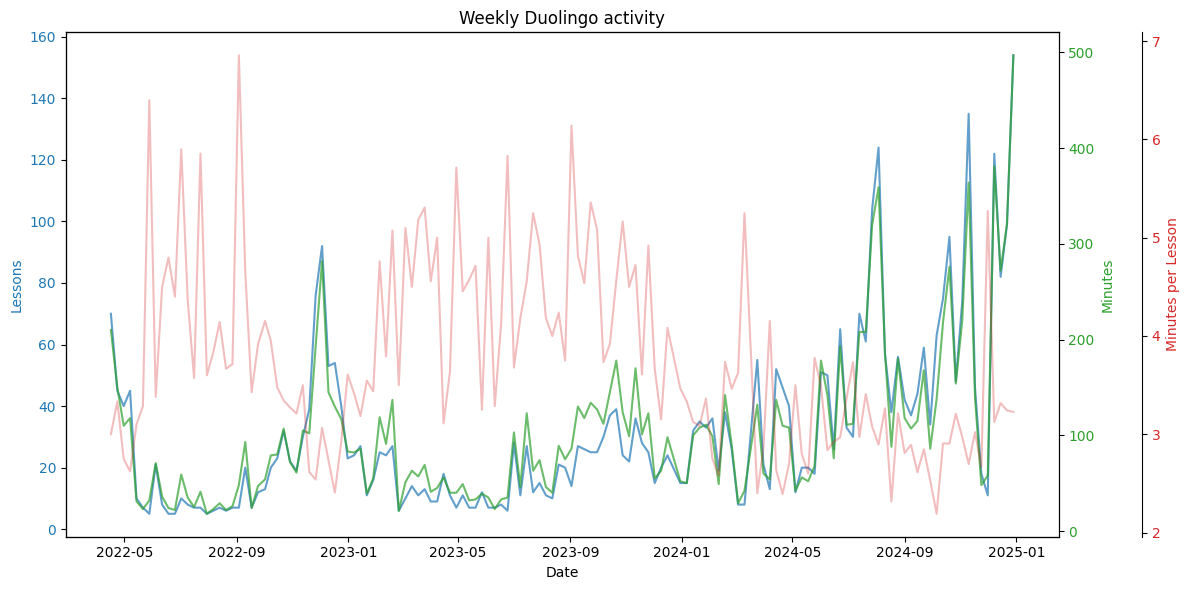

In [4]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# lessons
ax1.plot(df.index, df['lessons'], color='tab:blue', label='Lessons', alpha=0.7)
ax1.set_xlabel('Date')
ax1.set_ylabel('Lessons', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# minutes
ax2 = ax1.twinx()
ax2.plot(df.index, df['minutes'], color='tab:green', label='Minutes', alpha=0.7)
ax2.set_ylabel('Minutes', color='tab:green')
ax2.tick_params(axis='y', labelcolor='tab:green')

# speed
ax3 = ax1.twinx()
# set position of third axis so it does not overlap with the other two
# by moving it further out
ax3.spines['right'].set_position(('outward', 60))
ax3.plot(df.index, df['minutes/lesson'], color='tab:red', label='Minutes per Lesson', alpha=0.3)
ax3.set_ylabel('Minutes per Lesson', color='tab:red')
ax3.tick_params(axis='y', labelcolor='tab:red')

plt.title('Weekly Duolingo activity')
plt.tight_layout()
plt.show()

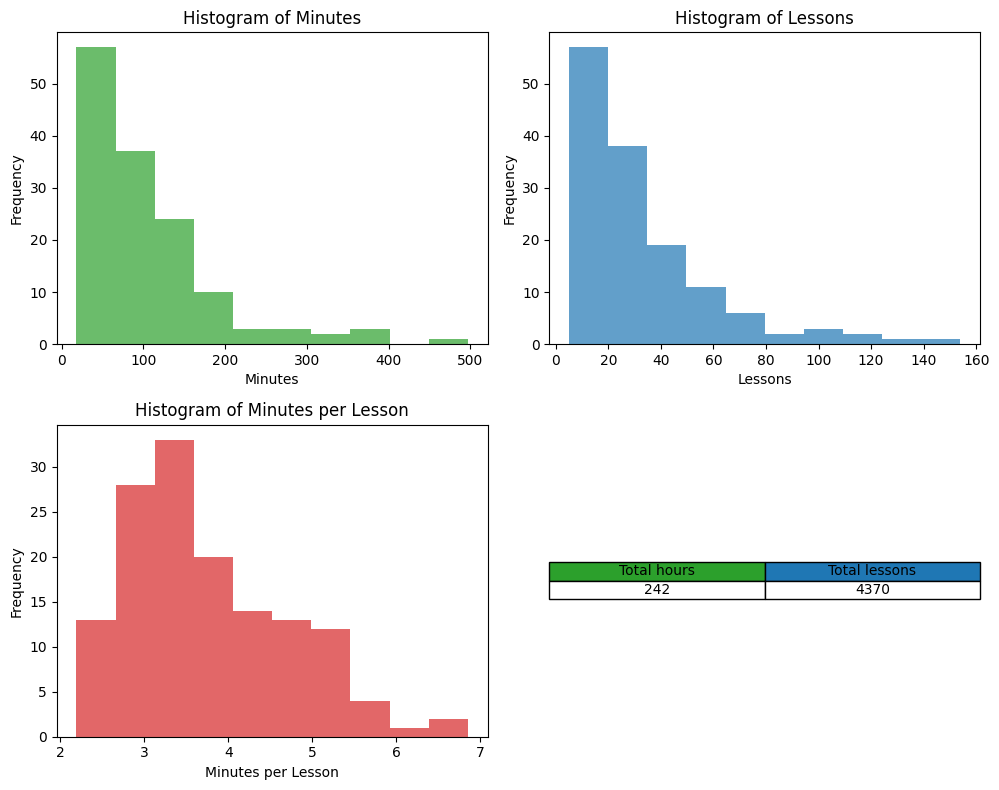

In [5]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = axs.flatten()

# minutes
axs[0].hist(df['minutes'], color='tab:green', alpha=0.7)
axs[0].set_title('Histogram of Minutes')
axs[0].set_xlabel('Minutes')
axs[0].set_ylabel('Frequency')

# lessons
axs[1].hist(df['lessons'], color='tab:blue', alpha=0.7)
axs[1].set_title('Histogram of Lessons')
axs[1].set_xlabel('Lessons')
axs[1].set_ylabel('Frequency')

# minutes/lessons
axs[2].hist(df['minutes/lesson'], color='tab:red', alpha=0.7)
axs[2].set_title('Histogram of Minutes per Lesson')
axs[2].set_xlabel('Minutes per Lesson')
axs[2].set_ylabel('Frequency')

# table
axs[3].axis('off') # turn off the axis for this subplot
axs[3].table(
    cellText=[[int(df['minutes'].sum() / 60), df['lessons'].sum()]],
    colLabels=['Total hours', 'Total lessons'], 
    loc='center', 
    cellLoc='center', 
    colColours=['tab:green', 'tab:blue'],
)

plt.tight_layout()
plt.show()